### GIS-2 Final Project


Step 1: Data acquisition and cleaning 

In [1]:
# Import necessary libraries for GIS data processing
import geopandas as gpd
import osmnx as ox
import rasterio
import requests
import zipfile
import os
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Set up OSMnx settings
ox.settings.log_console = True
ox.settings.use_cache = True

# Define data directory
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

# Define place name
PLACE_NAME = 'Graz, Austria'

# Define CRS for metric projections
# For Austria: EPSG:31256 (MGI / Austria Lambert) is recommended for official geodetic work
# Alternative: EPSG:32633 (UTM zone 33N) - but less accurate for Austria
CRS_METRIC = 'EPSG:31256'  # MGI / Austria Lambert - official Austrian CRS

In [2]:
# Load Graz city boundary and districts
graz_boundary = ox.geocode_to_gdf(PLACE_NAME).to_crs(CRS_METRIC)

# All 18 districts of Graz
OFFICIAL_DISTRICTS = [
    "Innere Stadt", "St. Leonhard", "Sankt Leonhard", "Geidorf", "Lend", "Gries",
    "Jakomini", "Liebenau", "St. Peter", "Sankt Peter", "Waltendorf", "Ries",
    "Mariatrost", "Andritz", "Gösting", "Eggenberg", "Wetzelsdorf", "Straßgang", "Puntigam"
]

# Get administrative boundaries from OSM and filter to Graz districts
all_admin = ox.features_from_place(PLACE_NAME, tags={'boundary': 'administrative'})
all_admin = all_admin[all_admin.geometry.type.isin(['Polygon', 'MultiPolygon'])].to_crs(CRS_METRIC)

districts = all_admin[all_admin['name'].isin(OFFICIAL_DISTRICTS)][['name', 'geometry']].copy()
districts = districts[districts.is_valid].reset_index(drop=True)

print(f"✓ Loaded {len(districts)} districts (total available: {len(OFFICIAL_DISTRICTS)})")

✓ Loaded 17 districts (total available: 19)


In [3]:
# Load medical facilities from OSM
print("Loading medical facilities...")

medical = ox.features_from_place(PLACE_NAME, tags={'amenity': ['hospital', 'clinic', 'doctors', 'pharmacy']})
medical = medical[medical.geometry.type == 'Point'].to_crs(CRS_METRIC)

# Remove duplicates
medical['geom_str'] = medical['geometry'].astype(str)
medical = medical.drop_duplicates(subset=['geom_str']).drop('geom_str', axis=1)

# Classify facility type
def classify_facility(row):
    name = str(row.get('name', '')).lower()
    amenity = str(row.get('amenity', '')).lower()
    if 'hospital' in name or 'krankenhaus' in name: return 'Hospital'
    if amenity == 'pharmacy' or 'apotheke' in name: return 'Pharmacy'
    if amenity == 'doctors' or 'arzt' in name: return 'Doctor'
    return 'Clinic'

medical['type'] = medical.apply(classify_facility, axis=1)
medical = medical[['name', 'type', 'geometry']].dropna(subset=['name']).reset_index(drop=True)

print(f"✓ Total facilities: {len(medical)}")
for t in medical['type'].unique():
    print(f"  • {t}: {len(medical[medical['type'] == t])}")

Loading medical facilities...
✓ Total facilities: 1054
  • Pharmacy: 53
  • Doctor: 989
  • Clinic: 12


In [4]:
# Load street network and residential areas
print("Loading streets and residential areas...")

street_graph = ox.graph_from_place(PLACE_NAME, network_type='drive')
streets = ox.graph_to_gdfs(street_graph, nodes=False).to_crs(CRS_METRIC)
streets = streets[streets.is_valid].reset_index(drop=True)

residential = ox.features_from_place(PLACE_NAME, tags={'landuse': 'residential'})
residential = residential[residential.geometry.type.isin(['Polygon', 'MultiPolygon'])].to_crs(CRS_METRIC)
residential = residential[residential.is_valid].reset_index(drop=True)

print(f"✓ Streets: {len(streets)} | Residential areas: {len(residential)}")

Loading streets and residential areas...
✓ Streets: 11233 | Residential areas: 302


In [5]:
# Load ALL administrative boundaries
all_admin = ox.features_from_place(
    PLACE_NAME,
    tags={"boundary": "administrative"}
)

all_admin = all_admin[
    all_admin.geometry.type.isin(["Polygon", "MultiPolygon"])
].to_crs(CRS_METRIC)

# Official Graz districts (Stadtbezirke)
official_districts = [
    "Innere Stadt", "Sankt Leonhard", "Geidorf", "Lend", "Gries",
    "Jakomini", "Liebenau", "Sankt Peter", "Waltendorf", "Ries",
    "Mariatrost", "Andritz", "Gösting", "Eggenberg",
    "Wetzelsdorf", "Straßgang", "Puntigam"
]

districts = all_admin[all_admin["name"].isin(official_districts)].copy()

print("Number of districts:", len(districts))


Number of districts: 17


In [6]:
# Load population raster (GHSL)
print("Loading population data...")

ghsl_tif = Path(r'C:\Users\adily\FINAL\GIS_2_Final\GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif')

if not ghsl_tif.exists():
    print(f"Error: File not found at {ghsl_tif}")
else:
    with rasterio.open(ghsl_tif) as src:
        graz_bounds = graz_boundary.to_crs(src.crs).total_bounds
        window = rasterio.windows.from_bounds(*graz_bounds, src.transform)
        pop_data = src.read(1, window=window)
        
        clipped_tif = DATA_DIR / 'graz_population.tif'
        with rasterio.open(clipped_tif, 'w', driver='GTiff', height=pop_data.shape[0], 
                          width=pop_data.shape[1], count=1, dtype=pop_data.dtype, 
                          crs=src.crs, transform=src.window_transform(window)) as dst:
            dst.write(pop_data, 1)
        
        print(f"✓ Population raster loaded and clipped")

Loading population data...
✓ Population raster loaded and clipped


## Step 2: Calculate & Visualize Distribution

In this step, we calculate the density and distribution of key categories:
- Medical facilities (hospitals, pharmacies, GPs, rescue stations)
- Population (from GHSL raster)
- Residential areas
- Street network

We use appropriate metrics:
- **Kernel Density Estimation (KDE)** for point-based data (medical facilities) to show smooth density surfaces.
- **Hexagonal binning** for aggregating point densities into hexagons for better visualization.
- **Choropleth maps** by districts for aggregated statistics (e.g., population density, facility counts per district).
- **Zonal statistics** for population raster aggregated to districts.

Visualizations include maps with color scales, legends, and overlays.

In [7]:
# Import visualization libraries and calculate population per district
import seaborn as sns
from rasterstats import zonal_stats
import folium
from folium.plugins import HeatMap

print("Calculating population statistics by district...")

with rasterio.open(clipped_tif) as src:
    districts_proj = districts.to_crs(src.crs)
    stats = zonal_stats(districts_proj, str(clipped_tif), stats=['sum'])
    districts['population'] = [s.get('sum', 0) for s in stats]
    
    # Scale down if unrealistic
    if districts['population'].sum() > 500000:
        districts['population'] = districts['population'] / 10
    
    districts['area_km2'] = districts.geometry.area / 1_000_000
    districts['pop_density'] = districts['population'] / districts['area_km2'].clip(lower=0.1)

print(f"✓ Total population: {districts['population'].sum():.0f}")
print(f"✓ Average density: {districts['pop_density'].mean():.1f} people/km²")

Calculating population statistics by district...
✓ Total population: 316742
✓ Average density: 3663.8 people/km²


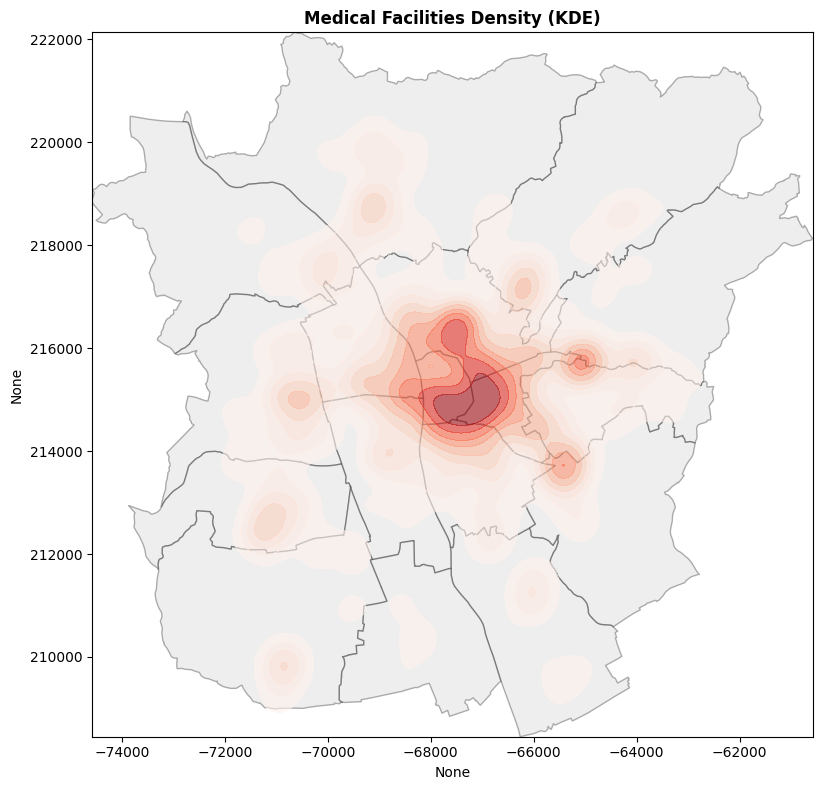

✓ KDE map saved


In [8]:
# KDE visualization - medical facilities density
bounds = graz_boundary.total_bounds

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
graz_boundary.plot(ax=ax, color='lightgray', alpha=0.5)
districts.plot(ax=ax, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=medical, x=medical.geometry.x, y=medical.geometry.y, 
            fill=True, cmap='Reds', alpha=0.6, ax=ax, bw_adjust=0.5)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities Density (KDE)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'medical_kde.png', dpi=300)
plt.show()

print("✓ KDE map saved")

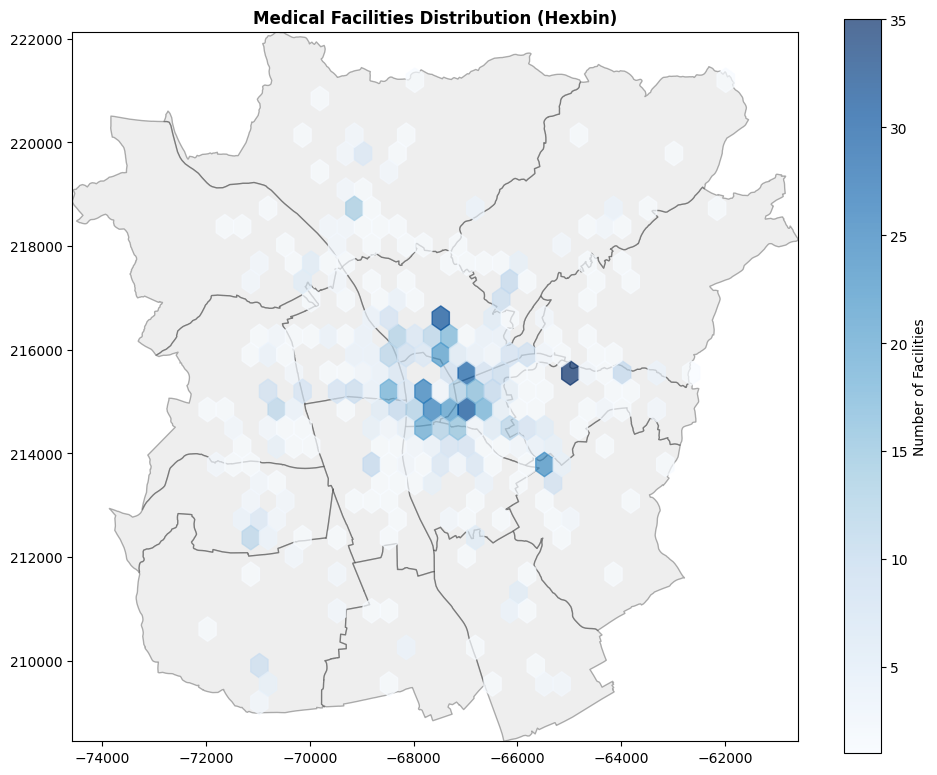

✓ Hexbin map saved


In [9]:
# Hexagonal binning visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
graz_boundary.plot(ax=ax, color='lightgray', alpha=0.5)
districts.plot(ax=ax, color='white', edgecolor='black', alpha=0.3)

hb = ax.hexbin(medical.geometry.x, medical.geometry.y, gridsize=30, cmap='Blues', alpha=0.7, mincnt=1)
plt.colorbar(hb, ax=ax, label='Number of Facilities')

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities Distribution (Hexbin)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'medical_hexbin.png', dpi=300)
plt.show()

print("✓ Hexbin map saved")

Creating medical facilities by district map...


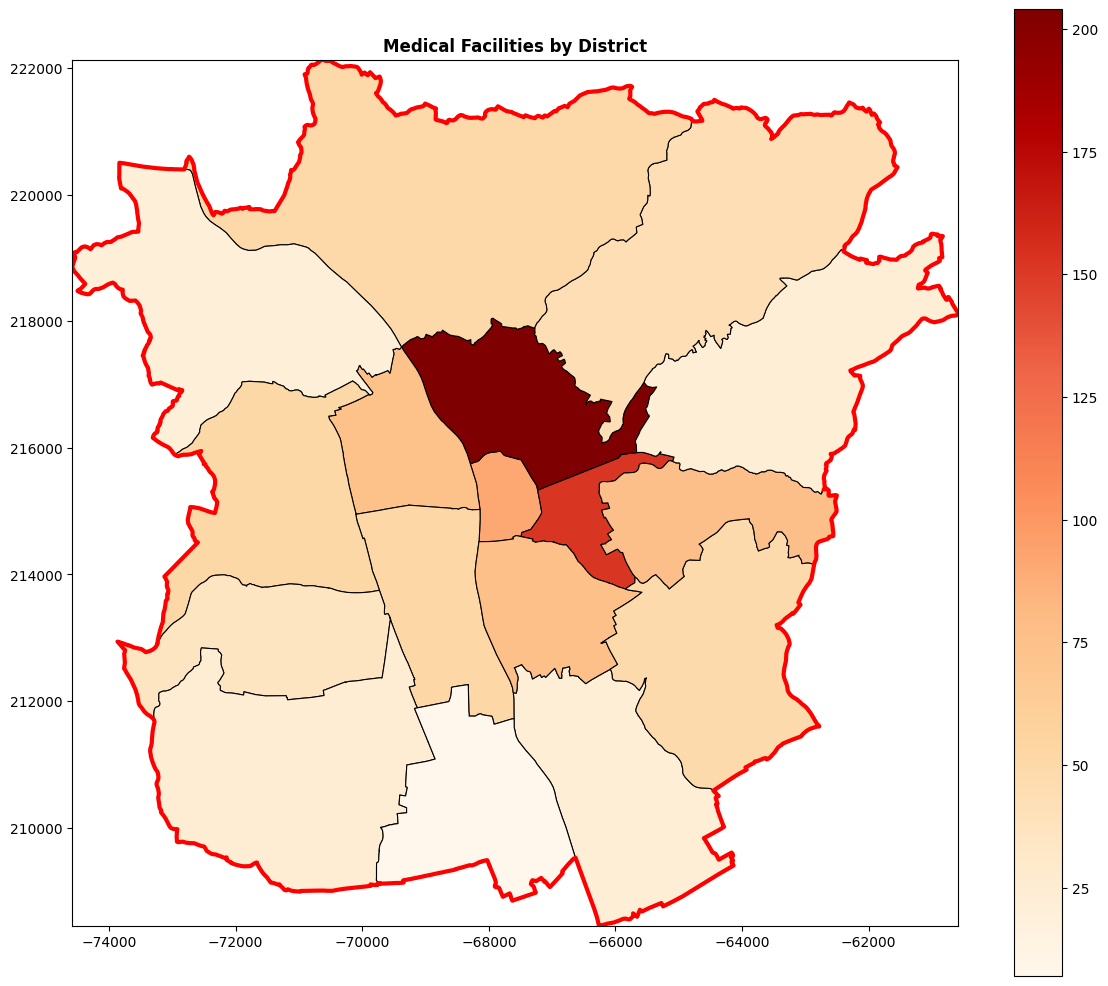

✓ Choropleth map saved


In [10]:
# Choropleth map - medical facilities by district
print("Creating medical facilities by district map...")

medical_in_districts = gpd.sjoin(medical, districts[['name', 'geometry']], how='left', predicate='within')
facility_counts = medical_in_districts['name_right'].value_counts().reset_index(name='count')
facility_counts.columns = ['name', 'count']

districts_stats = districts.copy()
districts_stats = districts_stats.merge(facility_counts, left_on='name', right_on='name', how='left')
districts_stats['count'] = districts_stats['count'].fillna(0).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
districts_stats.plot(column='count', ax=ax, cmap='OrRd', legend=True, edgecolor='black', linewidth=0.8)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=3)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities by District', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'medical_by_district.png', dpi=150)
plt.show()

print("✓ Choropleth map saved")

Creating population by district map...


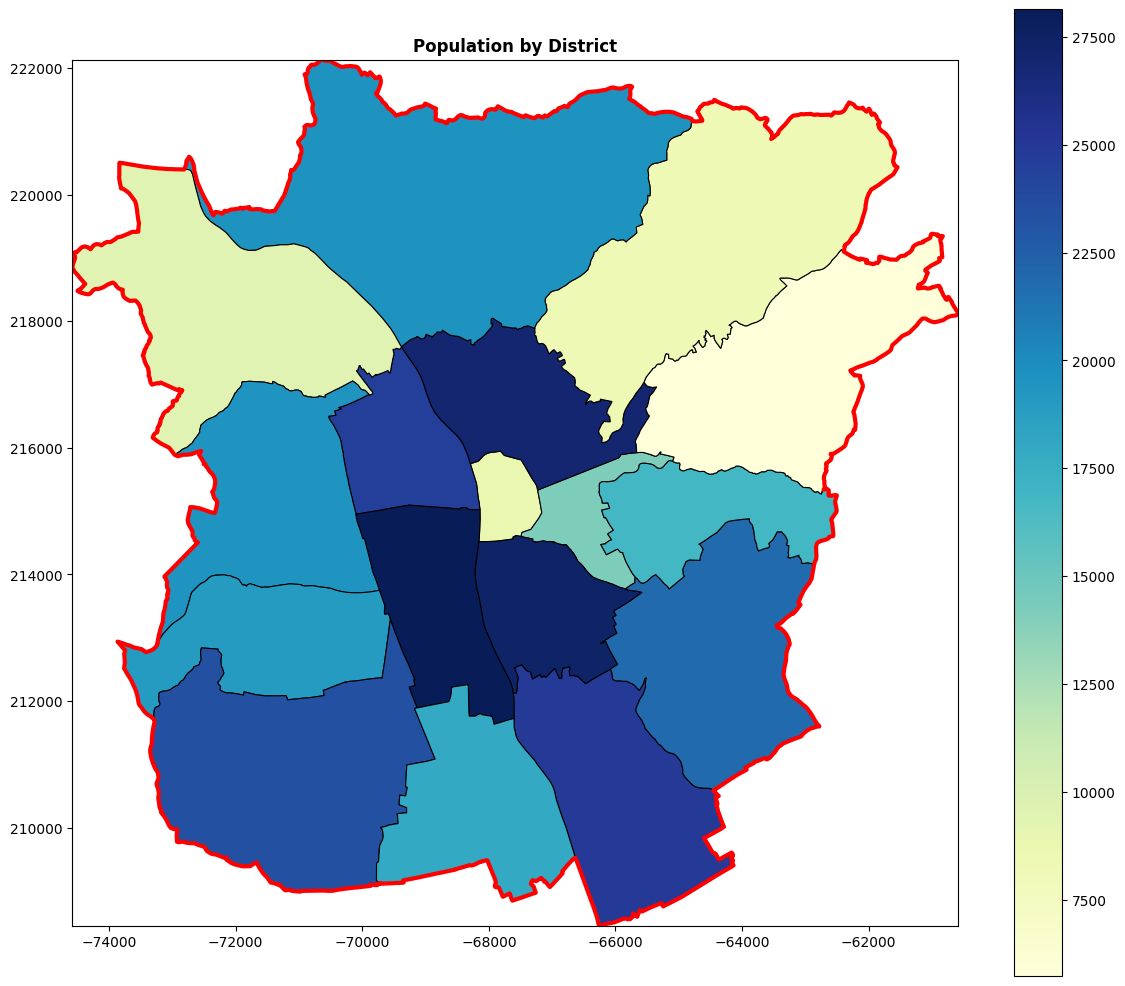

✓ Population map saved


In [11]:
# Choropleth map - population by district
print("Creating population by district map...")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
districts.plot(column='population', ax=ax, cmap='YlGnBu', legend=True, edgecolor='black', linewidth=0.8)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=3)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Population by District', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'population_by_district.png', dpi=150)
plt.show()

print("✓ Population map saved")

In [12]:
# Convert to WGS84 for web maps
print("Converting to WGS84 for web mapping...")

districts_wgs = districts.to_crs('EPSG:4326')
districts_stats_wgs = districts_stats.to_crs('EPSG:4326')
graz_boundary_wgs = graz_boundary.to_crs('EPSG:4326')
medical_wgs = medical.to_crs('EPSG:4326')

graz_center = graz_boundary_wgs.geometry.centroid.iloc[0]

print(f"✓ Map center: ({graz_center.y:.4f}, {graz_center.x:.4f})")

Converting to WGS84 for web mapping...
✓ Map center: (47.0751, 15.4394)


Creating statistics...


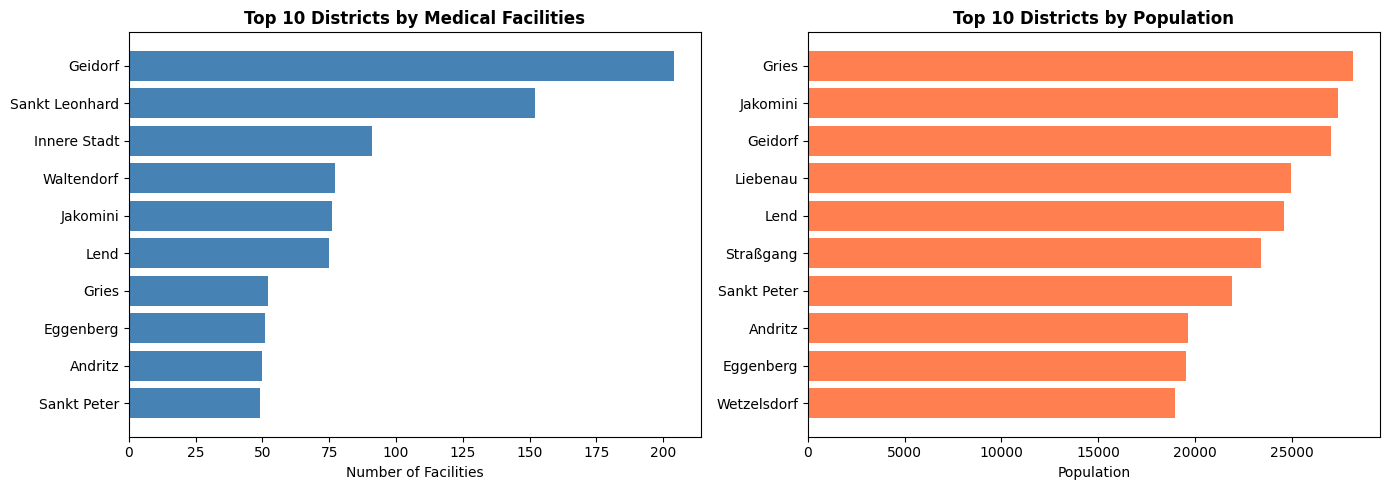


ANALYSIS SUMMARY
Total facilities: 1054
  • Pharmacy: 53
  • Doctor: 989
  • Clinic: 12

Total population: 316742
Total districts: 17


In [13]:
# Statistics and analysis
print("Creating statistics...")

# Top medical districts
medical_in_districts = gpd.sjoin(medical, districts[['name', 'geometry']], how='left', predicate='within')
fac_counts = medical_in_districts['name_right'].value_counts().reset_index(name='count')
fac_counts.columns = ['name', 'count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Top 10 medical facilities districts
top_med = fac_counts.nlargest(10, 'count').sort_values('count')
ax1.barh(range(len(top_med)), top_med['count'].values, color='steelblue')
ax1.set_yticks(range(len(top_med)))
ax1.set_yticklabels(top_med['name'].values)
ax1.set_xlabel('Number of Facilities')
ax1.set_title('Top 10 Districts by Medical Facilities', fontweight='bold')

# Top 10 population districts
top_pop = districts.nlargest(10, 'population').sort_values('population')
ax2.barh(range(len(top_pop)), top_pop['population'].values, color='coral')
ax2.set_yticks(range(len(top_pop)))
ax2.set_yticklabels(top_pop['name'].values)
ax2.set_xlabel('Population')
ax2.set_title('Top 10 Districts by Population', fontweight='bold')

plt.tight_layout()
plt.savefig(DATA_DIR / 'statistics_summary.png', dpi=150)
plt.show()

# Print summary
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Total facilities: {len(medical)}")
for t in medical['type'].unique():
    print(f"  • {t}: {len(medical[medical['type'] == t])}")
print(f"\nTotal population: {districts['population'].sum():.0f}")
print(f"Total districts: {len(districts)}")
print("="*60)

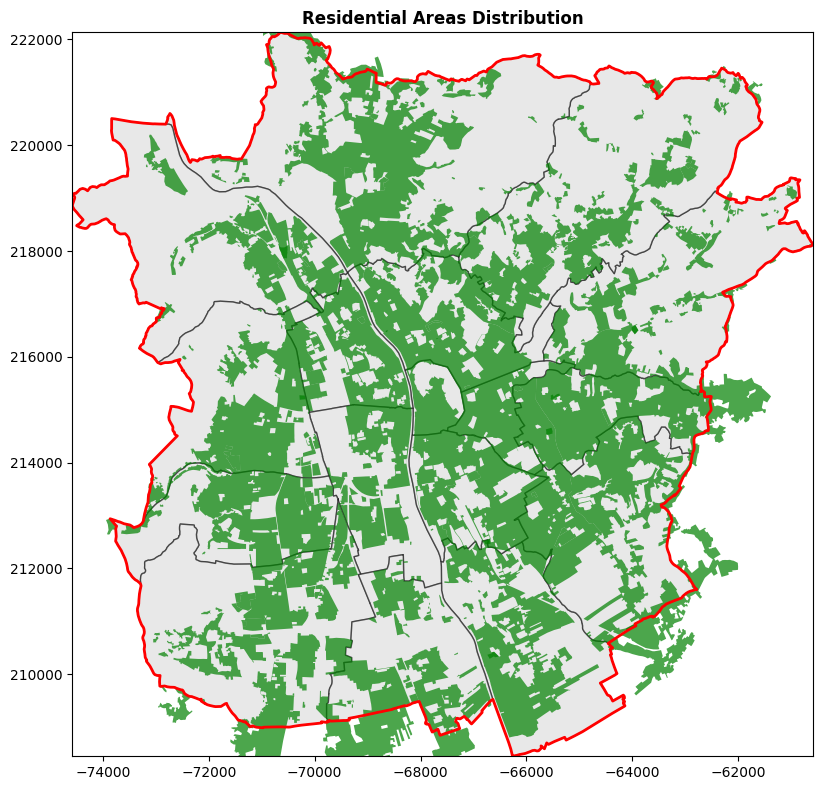

✓ Residential map saved


In [14]:
# Residential areas map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
residential.plot(ax=ax, color='green', alpha=0.7)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Residential Areas Distribution', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'residential_distribution.png', dpi=300)
plt.show()

print("✓ Residential map saved")

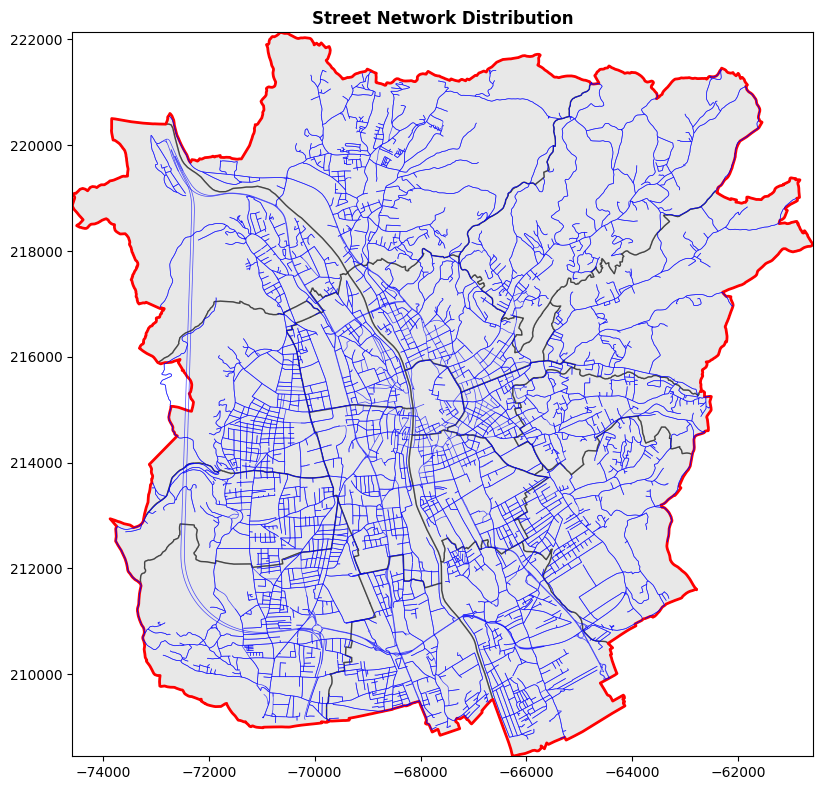

✓ Street network map saved


In [15]:
# Street network map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
streets.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.7)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Street Network Distribution', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'street_network.png', dpi=300)
plt.show()

print("✓ Street network map saved")

In [16]:
# Create interactive web map with Folium
print("Creating interactive map...")

# Base map
m = folium.Map(location=[graz_center.y, graz_center.x], zoom_start=12, tiles='OpenStreetMap')

# Add layers
folium.GeoJson(graz_boundary_wgs.__geo_interface__, name='City Boundary').add_to(m)
folium.GeoJson(districts_wgs.__geo_interface__, name='Districts').add_to(m)

# Heat map of medical facilities
heat_data = [[row.geometry.y, row.geometry.x] for idx, row in medical_wgs.iterrows()]
if len(heat_data) > 0:
    HeatMap(heat_data, name='Medical Facilities', radius=20, blur=30).add_to(m)

folium.LayerControl().add_to(m)

# Save
map_path = str(DATA_DIR / 'graz_interactive_map.html')
m.save(map_path)

print(f"✓ Interactive map saved: {map_path}")
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("Maps saved:")
print("  • medical_kde.png - KDE density")
print("  • medical_hexbin.png - Hexbin distribution")
print("  • medical_by_district.png - Choropleth by district")
print("  • population_by_district.png - Population choropleth")
print("  • statistics_summary.png - Bar charts")
print("  • residential_distribution.png - Residential areas")
print("  • street_network.png - Street network")
print("  • graz_interactive_map.html - Interactive web map")
print("="*60)

Creating interactive map...
✓ Interactive map saved: data\graz_interactive_map.html

ANALYSIS COMPLETE
Maps saved:
  • medical_kde.png - KDE density
  • medical_hexbin.png - Hexbin distribution
  • medical_by_district.png - Choropleth by district
  • population_by_district.png - Population choropleth
  • statistics_summary.png - Bar charts
  • residential_distribution.png - Residential areas
  • street_network.png - Street network
  • graz_interactive_map.html - Interactive web map
